# Acute Myeloid Leukemia (AML) Case Study

This notebook focuses on modeling and explainability for the **Acute Myeloid Leukemia (AML)** case study based on the RNA-seq dataset. The data originates from [Warnat-Herresthal et al. (2020)](https://doi.org/10.1016/j.isci.2019.100780), *"Scalable prediction of acute myeloid leukemia using high-dimensional machine learning and blood transcriptomics."* The dataset includes **log2-transformed, normalized gene expression values** for over **12,000 genes**, measured across a broad and heterogeneous collection of patient samples. These include:

* **AML patients**
* Patients with other **leukemia subtypes** (e.g., CLL, CML, ALL, MDS)
* **Healthy individuals**
* Individuals with **non-leukemic diseases**

Gene expression profiling was performed using both **Affymetrix microarrays (HG-U133A and HG-U133 2.0)** and **RNA-seq** technologies. In this case study, we focus specifically on the **RNA-seq dataset**, which offers higher resolution and broader coverage. Processing of the dataset and an exploratory data analysis was performed in the previous notebook.

### Objectives of this notebook

This notebook focuses on modeling and explainability for the AML case study based on the RNA-seq dataset. Specifically, we aim to:

* **Train a Random Forest model** to accurately **predict AML status** from high-dimensional gene expression data.
* Apply **Forest-Guided Clustering (FGC)** to uncover how the model internally organizes samples based on shared decision pathways.
* **Interpret model behavior** by identifying the most influential genes that drive separation between AML and non-AML samples.
* Investigate **potential confounding factors**, such as tissue type or study origin, that may inadvertently impact model decisions.


In [1]:
# load the required packages

import sys
import pickle

import numpy as np
import pandas as pd 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold
from sklearn.metrics import balanced_accuracy_score

## import the Forest-Guided Clustering package
from fgclustering import (
    forest_guided_clustering, 
    forest_guided_feature_importance, 
    plot_forest_guided_feature_importance, 
    plot_forest_guided_decision_paths,
    DistanceRandomForestProximity,
    ClusteringKMedoids,
)

# import untils fubnctions
sys.path.append('./')
import utils

/opt/anaconda3/envs/fgc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ensure reproducibility
seed = 1
np.random.seed(seed)

## Load Processed Data

In this step, we load the pre-processed RNA-Seq dataset prepared in the previous notebook. This dataset contains:
- Normalized and cleaned gene expression features (log₂-transformed)
- Curated metadata including Condition, Disease, Tissue, GSE, and sample_id
- Annotated binary labels distinguishing AML from other samples

In [3]:
# load previously stored data
with open(f'./data/dataset3.pickle', "rb") as handle:
    data = pickle.load(handle)

data.head()

,PAX8,CCL5,MMP14,DTX2P1-UPK3BP1-PMS2P11,BAD,PRPF8,CAPNS1,RPL35,EIF4G2,EIF3D,...,ACTB,GAPDH,MIR3648-2,MIR3648-1,sample_id,Dataset,GSE,Condition,Disease,Tissue
55,429.141908,679.596678,46.224306,937.959260,1608.761060,27720.632747,12820.855077,13999.225407,30957.224082,14112.165495,...,207249.750988,265747.017753,17.718712,17.718712,GSM1202460,3,Simon (GSE49601),0_Control,ALL,PBMC
56,342.484974,770.785271,184.880818,2558.886562,1188.066680,24220.254267,12869.839728,13935.471198,18645.105479,10982.375835,...,91774.333718,38670.101249,17.562749,17.562749,GSM1202461,3,Simon (GSE49601),0_Control,ALL,BM
57,346.029244,178.616938,119.287279,1148.201355,697.178980,18303.955572,7988.833487,4892.082001,28528.632335,8830.426446,...,158699.288796,82700.438196,6.077328,6.077328,GSM1202462,3,Simon (GSE49601),0_Control,ALL,PBMC
58,273.100560,105.789293,51.844630,857.681016,534.301040,13737.032555,4964.479248,21213.436597,20873.148863,7660.995693,...,81507.355855,113369.609393,1.480776,1.480776,GSM1202463,3,Simon (GSE49601),0_Control,ALL,BM
59,219.733952,815.029434,43.389352,951.904754,349.511528,13659.251313,4370.811721,7804.724654,38471.198612,5333.294820,...,69913.344447,50200.238258,3.196909,3.196909,GSM1202464,3,Simon (GSE49601),0_Control,ALL,BM


## Case Study 1: Cross-Study Prediction of AML

As outlined in the original publication Warnat-Herresthal et al., 2020, the RNA-Seq dataset comprises gene expression profiles from 23 independent studies sourced from the Gene Expression Omnibus (GEO). This high inter-study diversity introduces both biological variation and technical heterogeneity (e.g., batch effects), which must be carefully addressed in predictive modeling.

When building machine learning models on such multi-study data, the strategy for constructing training and testing sets plays a crucial role in determining the generalizability of the model. Two common approaches are:

1. **Random Sampling**
	- Samples for training and testing are randomly drawn from the entire pool, mixing samples from all 23 studies.
	- While often used in conventional settings, this approach does not account for study-specific biases or batch effects.
	- It may lead to overly optimistic performance estimates, as the model may implicitly learn to generalize within-study artifacts, which do not hold in truly independent settings.

2. **Cross-Study Sampling**
	- The training and test sets are constructed such that no study appears in both, i.e. if any sample from a study is used for training, all other samples from that study are excluded from the test set.
	- This mimics a real-world scenario where a model trained on past data is applied to a completely new cohort or study.
	- This method requires that each class (e.g., control, cancer) be sufficiently represented across multiple studies, otherwise, it can result in imbalanced splits.

For this case study, we apply the **cross-study sampling** strategy to evaluate how well models trained on multiple studies generalize to unseen studies. Specifically, we use a **Stratified Group K-Fold** approach to:
- Ensure stratification: maintain a balanced class distribution (e.g., cancer vs. control) in both training and testing sets.
- Enforce group exclusivity: each group (study) is assigned entirely to either the training or the test set, preventing data leakage between them.

This setup allows us to assess generalization across independent studies, reflecting more realistic use cases in clinical diagnostics or biomarker discovery.

*Note: For hyperparameter optimization during cross-validation, we also employ stratified group K-fold splitting to preserve this study-level exclusivity throughout the modeling pipeline*.

### Define Training and Test Set

To enable robust and generalizable model evaluation, we construct a **train-test split that respects both stratification and study-level grouping**. This is especially important in high-dimensional transcriptomic data, where samples from the same study may introduce **study-specific biases (batch effects)**.

We use `StratifiedGroupKFold` to split the data, whihc ensures:

* **Stratification** ensures that both training and test sets maintain similar proportions of the target classes (`Condition`: cancer vs control).
* **Grouping by GSE (study origin)** ensures that samples from a single study are not split across train and test sets, thereby **preventing data leakage** and simulating **real-world generalization to unseen cohorts**.

In [4]:
# define metadata and gene features
metadata = ["Condition", "Disease", "GSE", "sample_id", "Tissue", "Dataset"]
gene_features = data.drop(metadata, axis=1).columns

# define cross-validation strategy
cv = StratifiedGroupKFold(n_splits=5) # should approximate 80/20 split

# generate train, val and test sets
data_train_test = data.copy()
train_idx, test_idx = next(cv.split(data[gene_features], data["Condition"], data["GSE"]))
data_train_val, data_test = data.iloc[train_idx], data.iloc[test_idx]

print(f"Number of training samples {data_train_val.shape[0]} ({round(data_train_val.shape[0]/data_train_test.shape[0]*100)}%) with {sum(data_train_val["Condition"]=="0_Control")} control and {sum(data_train_val["Condition"]=="1_Cancer")} cancer samples and training studies: {list(set(data_train_val['GSE']))}")
print(f"Number of testing samples {data_test.shape[0]} ({round(data_test.shape[0]/data_train_test.shape[0]*100)}%) with {sum(data_test["Condition"]=="0_Control")} control and {sum(data_test["Condition"]=="1_Cancer")} cancer samples and testing studies: {list(set(data_test['GSE']))}")

Number of training samples 783 (66%) with 538 control and 245 cancer samples and training studies: ['Lavallee (GSE49642)', 'Wong (GSE79970)', 'Rojas.Pena (GSE67184)', 'Garzon (GSE63646)', 'Meldi (GSE61162)', 'Hoft (GSE87186)', 'Lavallee (GSE66917)', 'Spinella (GSE78785)', 'Dorr (GSE86884)', 'Simon (GSE49601)', 'Lavallee (GSE52656)', 'Bouquet (GSE63085)', 'GSE85712', 'GSE72790', 'Divinge (GSE58335)', 'Lavallee (GSE62190)', 'Chen (GSE32874)', 'Hoek (GSE64655)']
Number of testing samples 398 (34%) with 135 control and 263 cancer samples and testing studies: ['GSE81259', 'Lavallee (GSE67039)', 'Doss (GSE63703)', 'Henn (GSE45735)', 'GSE63816']


In [5]:
# split dataset into X and y and define groups with grouped cv
X_train_test = data[gene_features]
y_train_test = data["Condition"]

X_train_val = data_train_val[gene_features]
y_train_val = data_train_val["Condition"]
groups_train_val = data_train_val["GSE"]

X_test = data_test[gene_features]
y_test = data_test["Condition"]

**Details of the split:**

* The training set comprises **66% of the data (783 samples)**:

  * **538 control samples**
  * **245 cancer samples**
  * Drawn from **18 studies**

* The test set includes **34% of the data (398 samples)**:

  * **135 control samples**
  * **263 cancer samples**
  * Drawn from **5 unseen studies**, used exclusively for model evaluation

### Train a Random Forest Classifier

We train a Random Forest model to classify AML (cancer) vs. other (control) samples. To ensure optimal performance, we perform a grid search over key hyperparameters using Stratified Group K-Fold cross-validation, which preserves both class distribution and study separation. The parameter grid includes variations of tree depth, number of features, and leaf size. The best-performing model is selected based on validation accuracy and saved for reuse.

Finally, we evaluate the model on the training and independent test set using balanced accuracy, providing insight into both in-sample and out-of-sample performance. 

In [6]:
# define hyperparameter grid for Random Forest
grid = {"max_depth":[5, 10, 20], 
        "max_features": ['sqrt', 'log2'],
        "bootstrap": [True],
        "max_samples": [0.8],
        'n_estimators': [1000],
        'criterion': ['gini'],
        'min_samples_leaf': [1, 2, 5]
}

In [7]:
# define the cross-validation strategy
cv = StratifiedGroupKFold(n_splits=5)

# define the Random Forest classifier and a grid search with 5-fold stratified, grouped cross-validation and fit 
classifier = RandomForestClassifier(oob_score=True, random_state=42, n_jobs=4)
gridsearch_classifier = GridSearchCV(classifier, grid, cv=cv, scoring='accuracy', verbose=0)
gridsearch_classifier.fit(X_train_val, y_train_val, groups=groups_train_val)

# take the best estimator
rf_case1 = gridsearch_classifier.best_estimator_
print(gridsearch_classifier.best_params_)

# store the best model
with open(f'./data/rf_case1.pickle', 'wb') as handle:
    pickle.dump(rf_case1, handle, protocol=pickle.HIGHEST_PROTOCOL)

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_samples': 0.8, 'min_samples_leaf': 2, 'n_estimators': 1000}


In [8]:
# check model performance
y_pred_train_val = rf_case1.predict(X_train_val)
y_pred_test = rf_case1.predict(X_test)

# is the model performing reasonably on the training data?
print(f'Model Performance on training data: {round(balanced_accuracy_score(y_train_val, y_pred_train_val)*100,2)} % macro accuracy.')

# is the model performing reasonably on the test data?
print(f'Model Performance on test data: {round(balanced_accuracy_score(y_test, y_pred_test)*100,2)} % macro accuracy.')

Model Performance on training data: 100.0 % macro accuracy.
Model Performance on test data: 97.19 % macro accuracy.


The Random Forest model demonstrates excellent performance, achieving perfect accuracy on the training data and strong generalization with 96.63% balanced accuracy on the independent test set, indicating robust predictive power and minimal overfitting.

### Interpretation of the Random Forest Model Using Forest-Guided Clustering (FGC)

In this section, we apply Forest-Guided Clustering (FGC) to interpret the internal decision patterns of the trained Random Forest model. The goal is to uncover distinct subgroups of samples that follow similar decision paths and to identify which genes drive the separation between these subgroups.

We begin by determining the optimal number of clusters (k). FGC internally evaluates multiple values of k in the range 2–10 using stability-based clustering metrics (e.g., Jaccard Index) and selects the most stable solution. 


In [9]:
# define number of clusters and obtain clustered data
fgc = forest_guided_clustering(
    k=(2,10),
    estimator=rf_case1, 
    X=X_train_val, 
    y=y_train_val, 
    clustering_distance_metric=DistanceRandomForestProximity(), 
    clustering_strategy=ClusteringKMedoids(method="fasterpam", max_iter=100),
    JI_discart_value=0.9,
)

Using a sample size of 80.0 % of the input data for Jaccard Index computation.
Using range k = (2, 10) to optimize k.


Optimizing k: 100%|██████████| 9/9 [00:56<00:00,  6.28s/it]


Optimal number of clusters k = 8

Clustering Evaluation Summary:
 k    Score  Stable  Mean_JI                                                                                          Cluster_JI
 2 0.007326    True    1.000                                                                                    {1: 1.0, 2: 1.0}
 3 0.004884    True    0.992                                                                        {1: 0.976, 2: 0.999, 3: 1.0}
 4 0.002757    True    0.938                                                             {1: 0.999, 2: 0.984, 3: 0.961, 4: 0.81}
 5      NaN   False    0.893                                                   {1: 0.997, 2: 0.976, 3: 0.87, 4: 0.717, 5: 0.906}
 6 0.000617    True    0.956                                          {1: 0.919, 2: 0.993, 3: 0.993, 4: 0.965, 5: 0.868, 6: 1.0}
 7 0.000529    True    0.947                                {1: 0.928, 2: 0.994, 3: 0.876, 4: 0.989, 5: 0.849, 6: 0.993, 7: 1.0}
 8 0.000463    True    0.938   

Here, the best solution is found at k = 8 clusters, indicating the model recognizes 8 meaningful subgroups in the decision space. 

After identifying the clusters, we compute the feature importance for each cluster individually (local importance) and across the entire dataset (global importance), using the Wasserstein distance. These importance values highlight which genes are most relevant for distinguishing between different decision paths.

In [10]:
# calculate feature importance on the full gene set
feature_importance = forest_guided_feature_importance(
    X=X_train_val, 
    y=y_train_val, 
    cluster_labels=fgc.cluster_labels,
    model_type=fgc.model_type,
    feature_importance_distance_metric="wasserstein",
)

 51%|█████▏    | 6521/12708 [00:06<00:06, 1010.65it/s]

 - Skipping feature with zero variance.


 63%|██████▎   | 7953/12708 [00:07<00:04, 963.02it/s] 

 - Skipping feature with zero variance.


 68%|██████▊   | 8585/12708 [00:08<00:03, 1040.74it/s]

 - Skipping feature with zero variance.


 69%|██████▉   | 8807/12708 [00:08<00:03, 1074.55it/s]

 - Skipping feature with zero variance.


 78%|███████▊  | 9971/12708 [00:09<00:02, 1020.51it/s]

 - Skipping feature with zero variance.


 93%|█████████▎| 11760/12708 [00:11<00:00, 1054.58it/s]

 - Skipping feature with zero variance.


 98%|█████████▊| 12517/12708 [00:12<00:00, 1046.47it/s]

 - Skipping feature with zero variance.


100%|██████████| 12708/12708 [00:12<00:00, 1025.41it/s]


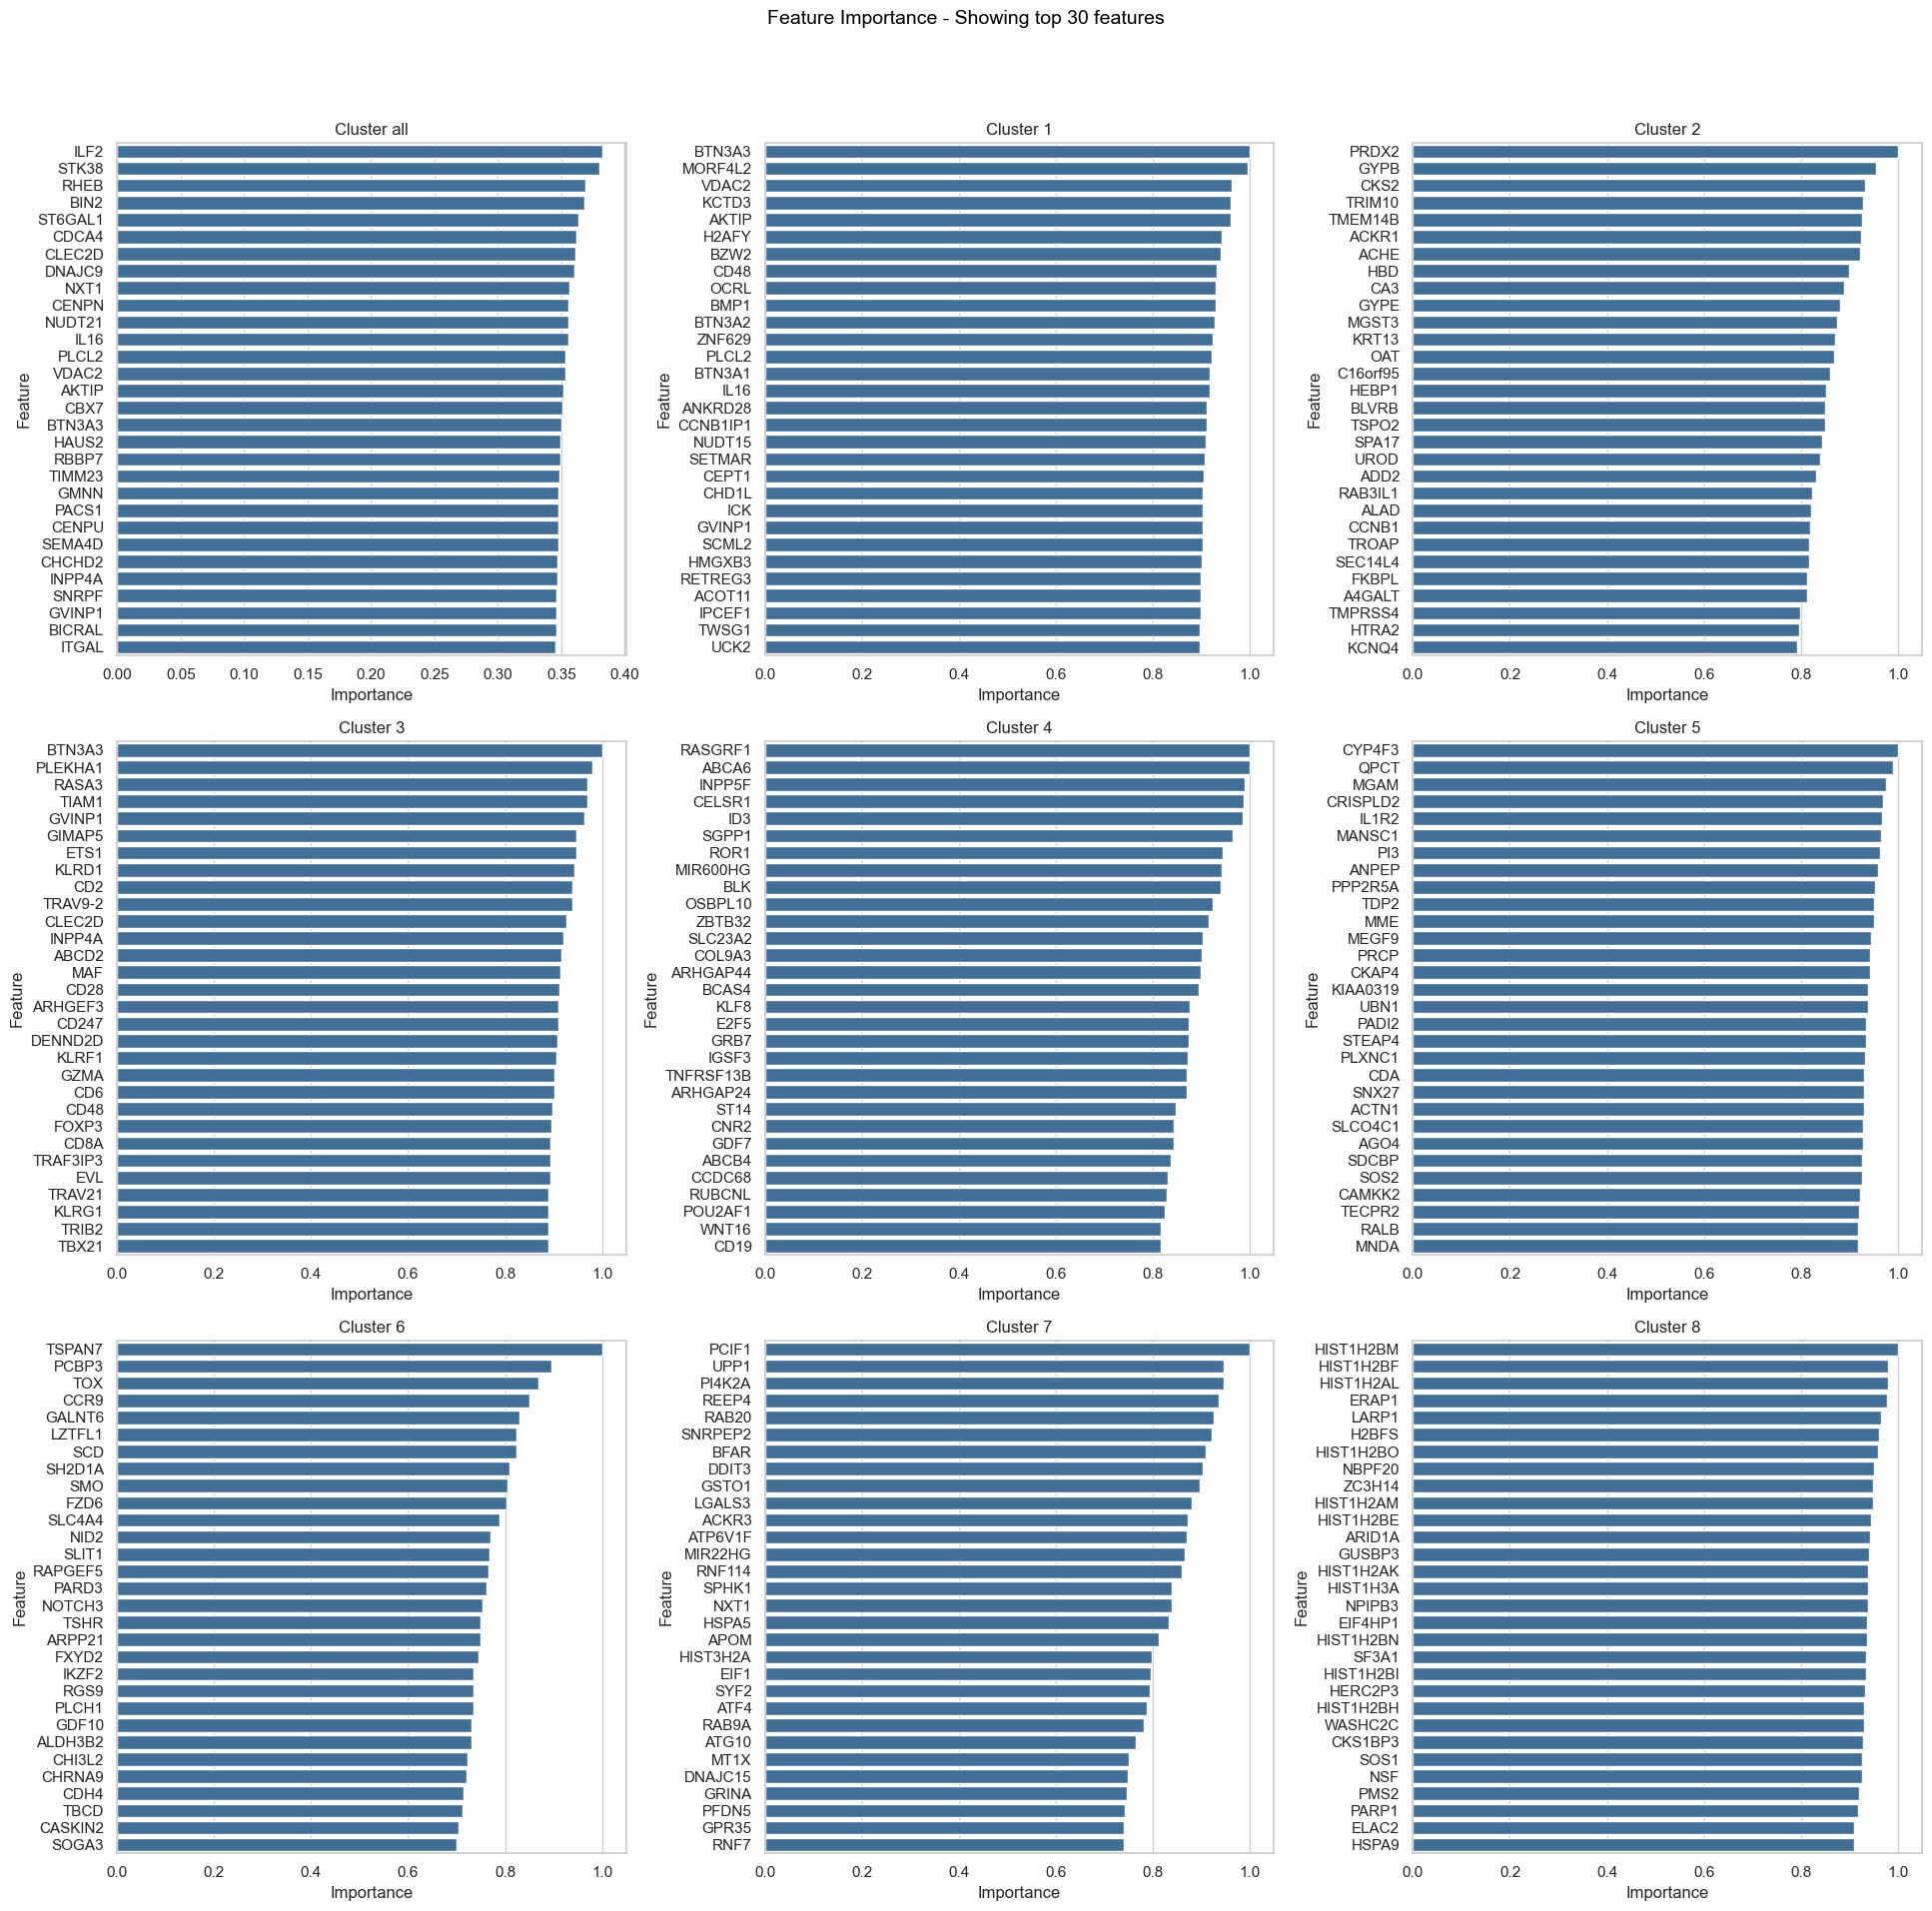

In [11]:
# plot top 30 globally important features
plot_forest_guided_feature_importance(
    feature_importance_local=feature_importance.feature_importance_local,
    feature_importance_global=feature_importance.feature_importance_global,
    top_n=30,
    num_cols=3,
    save="./results/case_study_1",
)

The feature importance plot shows that most clusters are defined by distinct gene expression signatures among their top 30 features, though three genes (BTN3A3, CD48, GVINP1)
appeared in both AML-enriched and control-associated cluster

### Feature Importance Analysis for the AML Cluster and Potential Confounders

Since our goal is to understand what distinguishes AML (Acute Myeloid Leukemia) samples from other samples, and to investigate potential confounding factors within the dataset, we focus on the 30 most informative features specific to the AML cluster and five genes which are know to be overexpressed in AML taken from [Handschuh (2019)](https://doi.org/10.1155/2019/7239206), *"Not Only Mutations Matter: Molecular Picture of Acute Myeloid Leukemia Emerging from Transcriptome Studies."*.

We begin by extracting the top 30 features based on local feature importance derived from the AML cluster in the forest-guided clustering and extend the feature set with relevant metadata attributes, including:
- Tissue type (e.g., PBMC, BM)
- Study origin (e.g., GSE identifiers)
- Disease label (e.g., ALL, CLL, healthy)

We then recompute the feature importance using this selected features to determine the joint contributions of both gene expression and metadata. Here, we use the Jensen-Shannon distance, which is well-suited for the incorporated categorical metadata (Tissue, GSE, and Disease) to investigate potential confounding factors. Finally, we visualize the decision path that explain the clustering structure and help reveal whether technical or biological covariates may act as confounding factors in distinguishing AML from non-AML samples. This analysis helps ensure that the separation of AML is not only biologically grounded but also robust to dataset heterogeneity.

In [28]:
# AML driver gene
aml_diff_genes = ["BAALC", "FLT3", "HOXA9", "MECOM", "WT1"]

# select the top 30 locally important features for teh AML cluster
feature_importance_local = feature_importance.feature_importance_local
feature_importance_local.columns = [f"Cluster_{i+1}" for i in range(feature_importance_local.shape[1])]
feature_importance_local.sort_values(by="Cluster_1", ascending=False, inplace=True)

top_cancer_genes = list(feature_importance_local.index[:30]) + aml_diff_genes
selected_metadata = ["Tissue", "GSE", "Disease"]

In [29]:
# calculate feature importance for the top cancer genes
feature_importance_top_cancer_genes = forest_guided_feature_importance(
    X=data_train_val[top_cancer_genes],
    y=data_train_val["Condition"], 
    cluster_labels=fgc.cluster_labels,
    model_type=fgc.model_type,
    feature_importance_distance_metric="wasserstein",
)

100%|██████████| 35/35 [00:00<00:00, 841.28it/s]


In [30]:
# calculate feature importance for the metadata
feature_importance_metadata = forest_guided_feature_importance(
    X=data_train_val[selected_metadata],
    y=data_train_val["Condition"], 
    cluster_labels=fgc.cluster_labels,
    model_type=fgc.model_type,
    feature_importance_distance_metric="jensenshannon",
)

100%|██████████| 3/3 [00:00<00:00, 247.30it/s]


In [31]:
data_clustering = pd.concat([feature_importance_metadata.data_clustering, feature_importance_top_cancer_genes.data_clustering], axis=1)
data_clustering = data_clustering.loc[:, ~data_clustering.columns.duplicated()]

Next, we visualize the decision path heatmap, which shows how expression patterns vary across clusters for the top-ranked features. Each cluster represents a group of samples sharing similar internal logic in the Random Forest, and the heatmap provides insight into how different expression profiles lead to the same or different classifications.

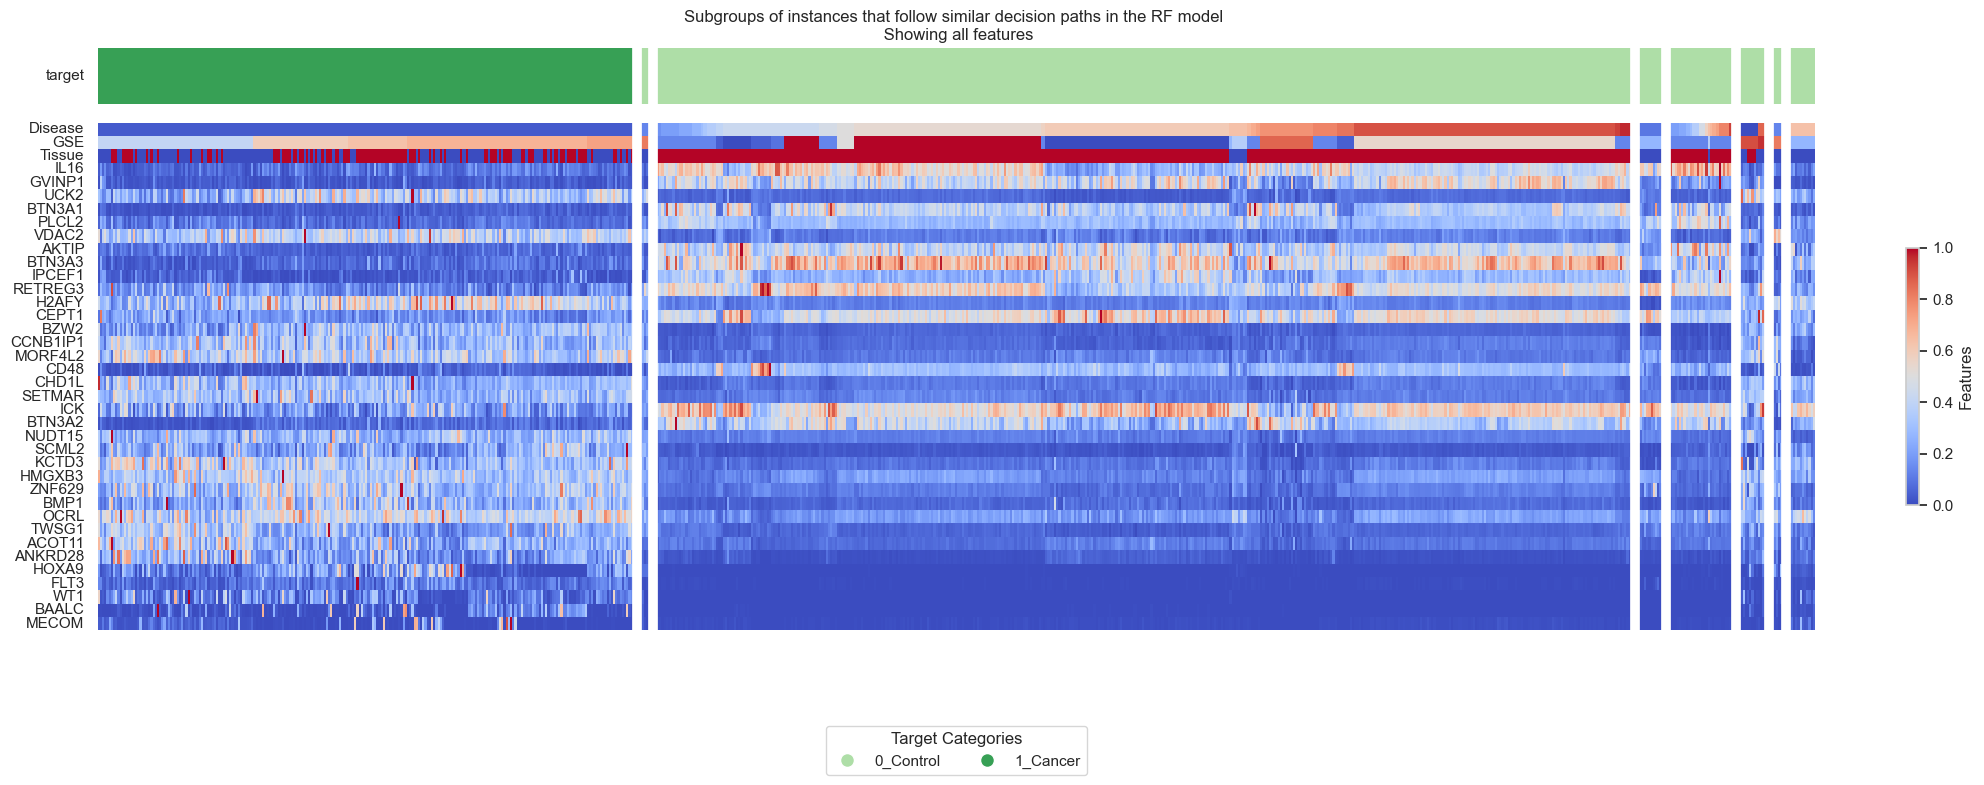

In [32]:
# plot decision path plot for the top cancer genes and metadata
plot_forest_guided_decision_paths(
    data_clustering=data_clustering,
    model_type=fgc.model_type,
    save="./results/case_study_1_selected_features",
    distributions=False,
    heatmap=True,
)

The model reveals eight distinct clusters based on samples that follow similar decision paths in the trained Random Forest. Notably, Cluster 1 contains exclusively AML samples, demonstrating that AML has a highly distinct expression signature that is well captured by the model. In contrast, non-AML samples are distributed across the remaining seven clusters (Clusters 2-8). Each of these clusters displays unique expression patterns, suggesting underlying biological diversity or the influence of confounding factors among non-AML diseases. These results underscore that although the model was trained on a binary classification task (AML vs. non-AML), it internally learned a nuanced structure in the data, grouping samples into meaningful subtypes based on shared decision logic. This layered insight can support subtype discovery and improve understanding of how predictive models behave in complex biomedical datasets.

To gain deeper insight into how the top genes are distributed across the eight clusters, we visualize decision path boxplots for key features alongside stacked bar plots of metadata variables. These plots help reveal how biological and technical factors such as tissue type, disease, and study origin are distributed across the clusters.

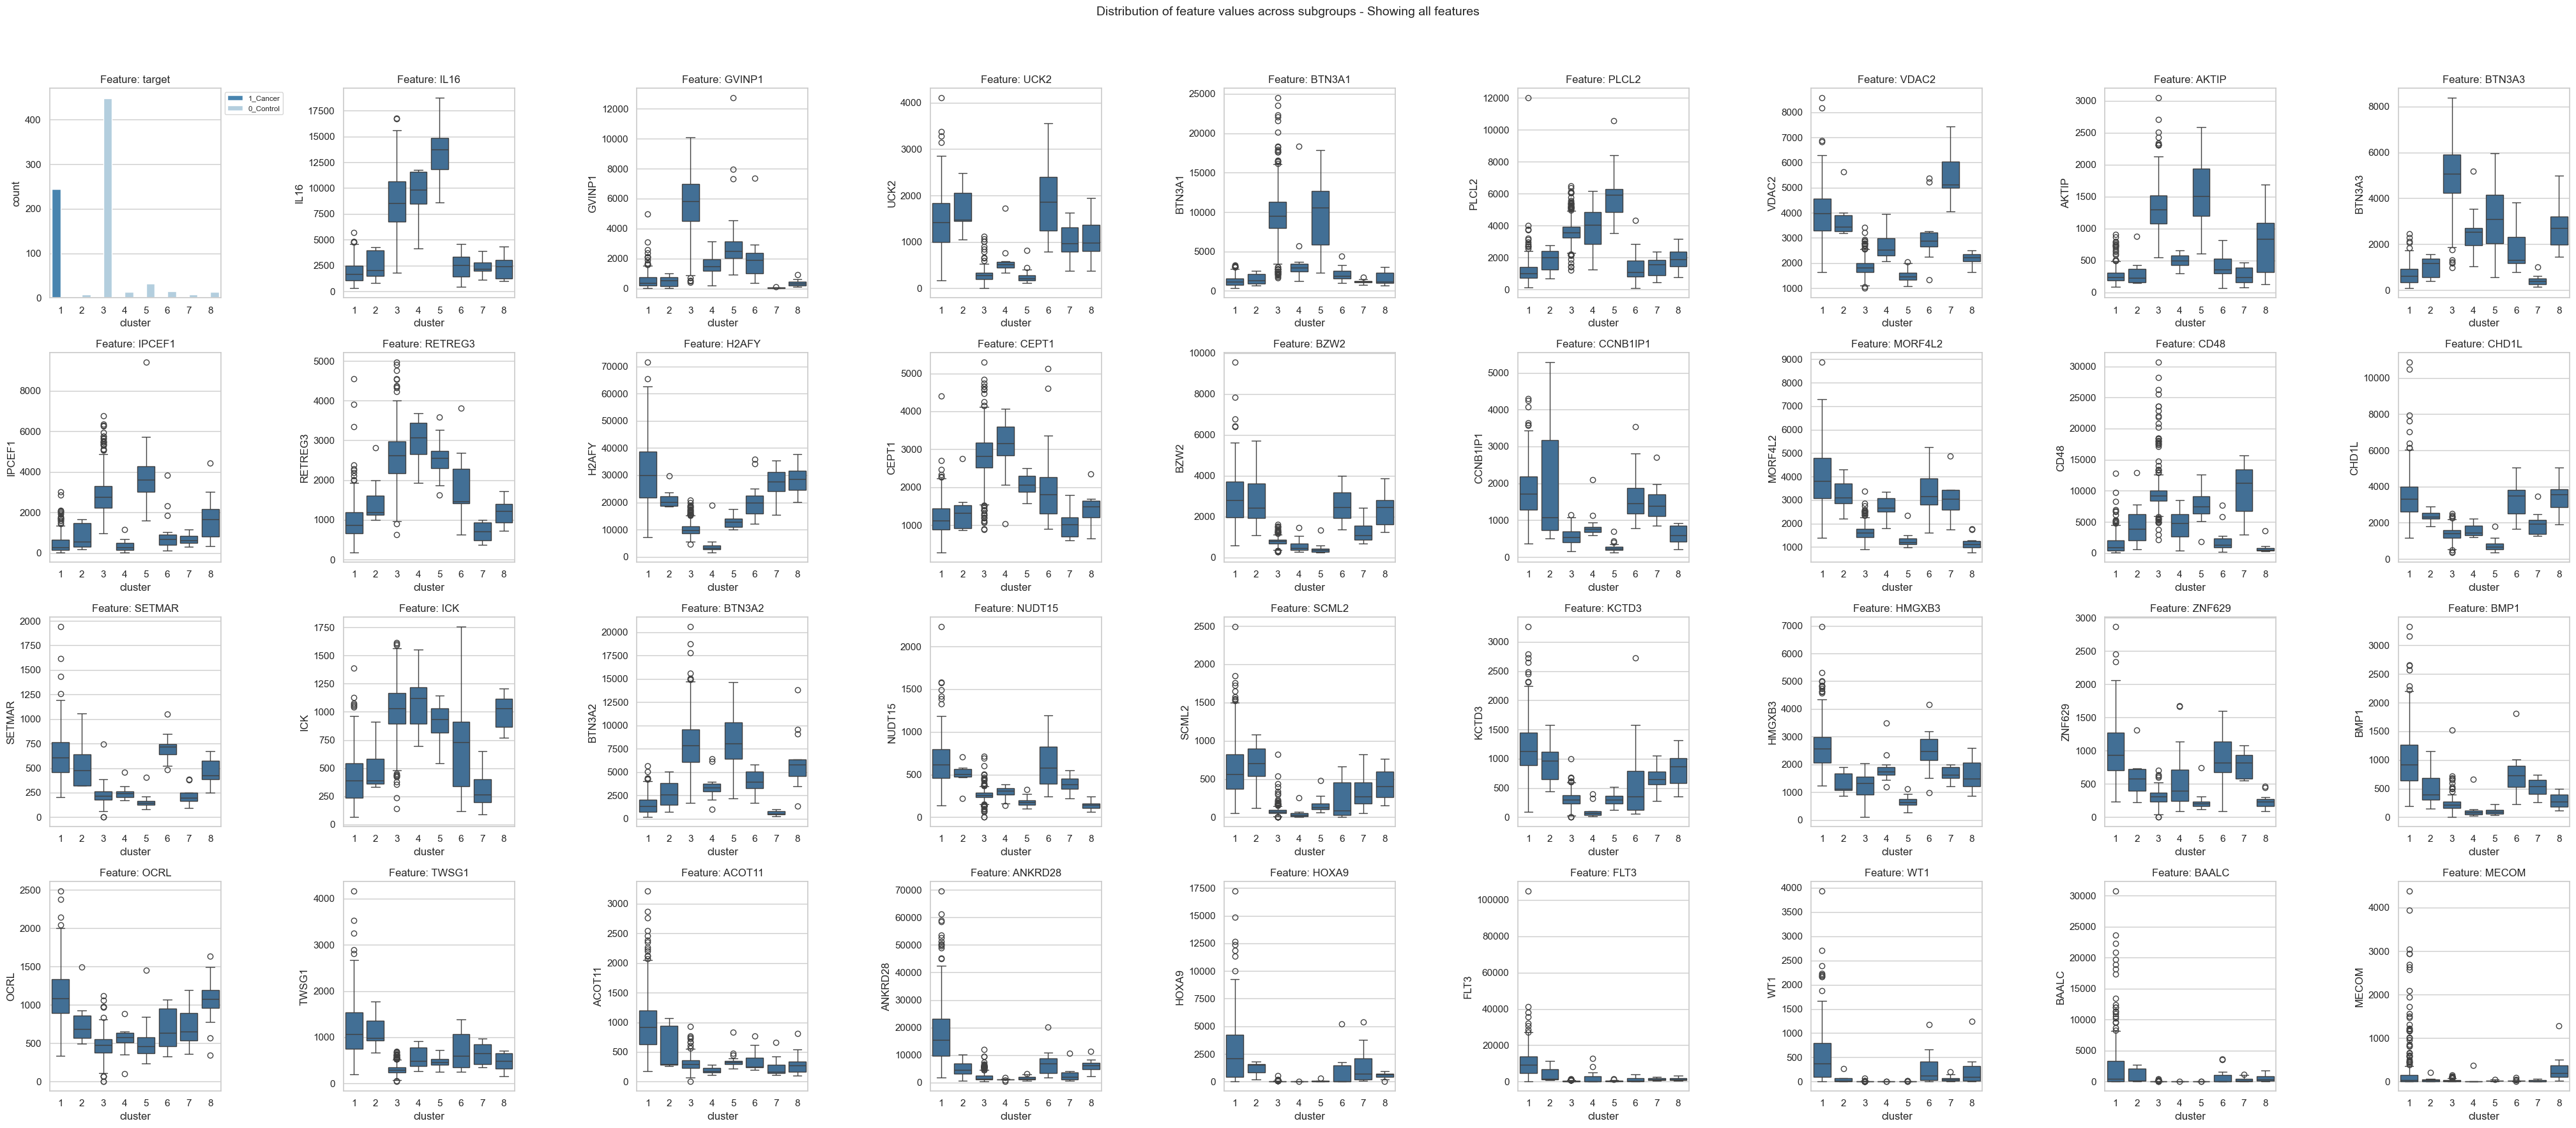

In [33]:
# plot decision path plot for the top cancer genes and metadata
plot_forest_guided_decision_paths(
    data_clustering=feature_importance_top_cancer_genes.data_clustering,
    model_type=fgc.model_type,
    num_cols=9,
    save="./results/case_study_1_selected_features",
    distributions=True,
    heatmap=False,
)

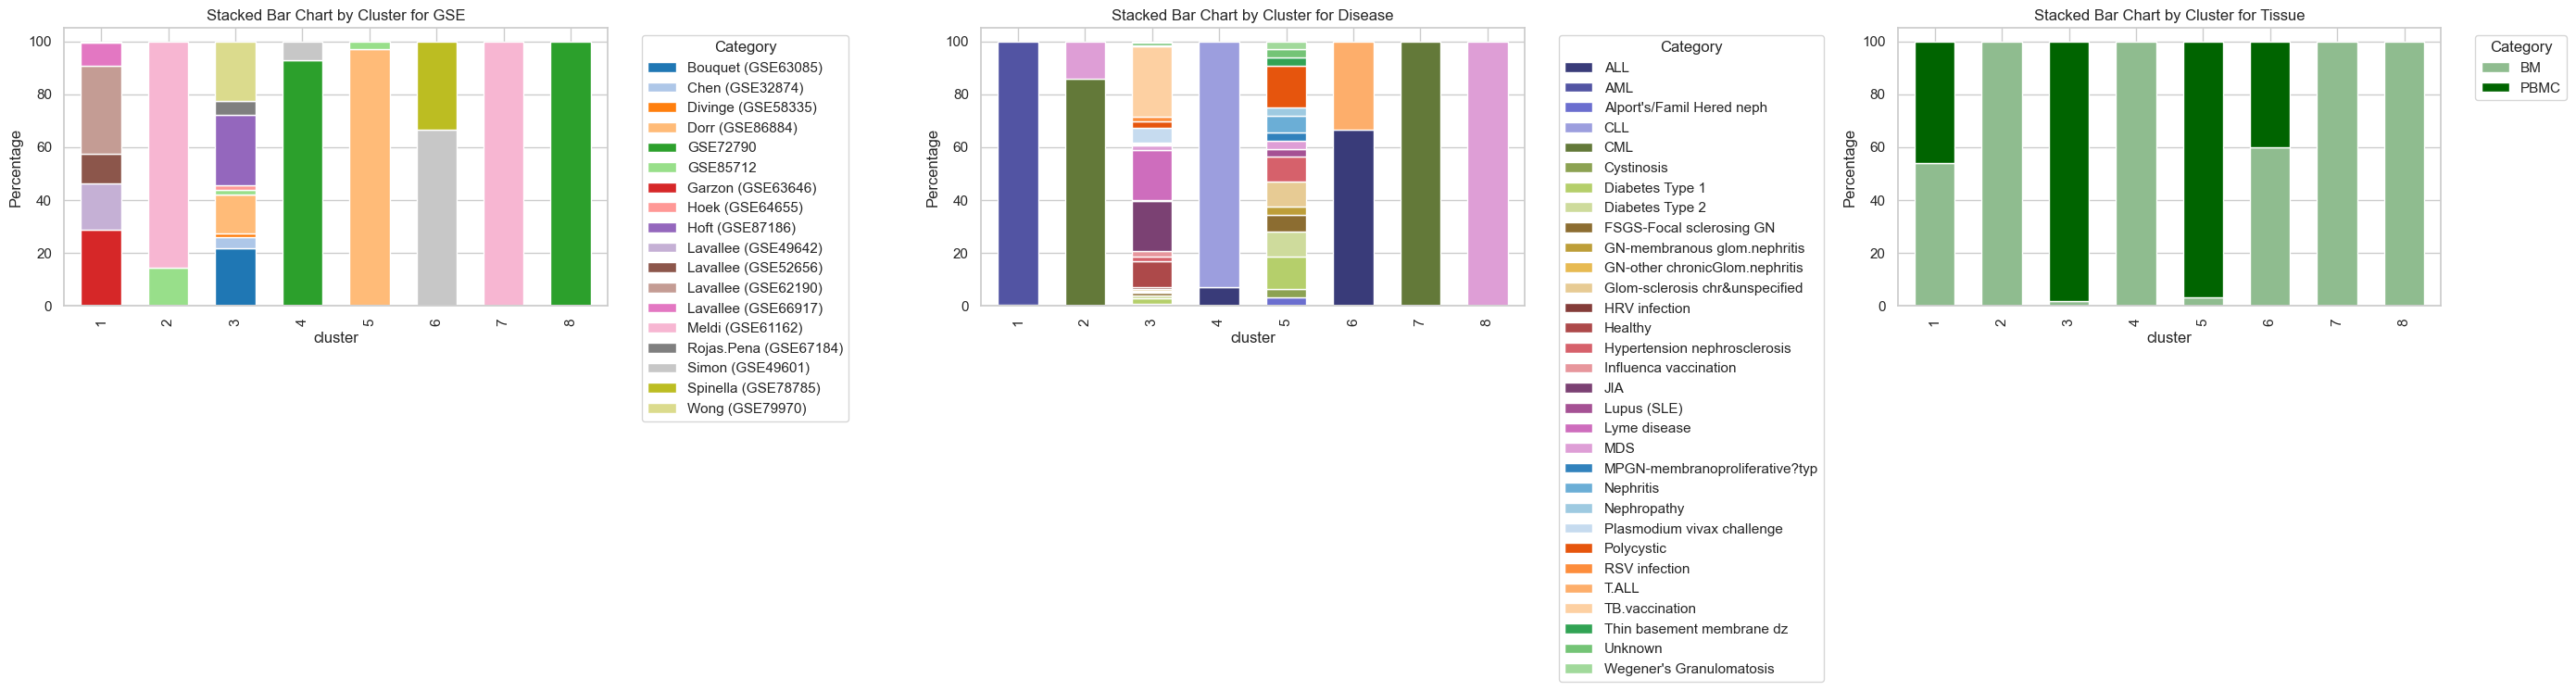

In [34]:
# visualize metadata as stacked bar plots
utils.plot_stacked_bar_chart(feature_importance_metadata, ["GSE", "Disease", "Tissue"], name="case_study_1_selected_features")

In [35]:
disease_distribution = feature_importance_metadata.data_clustering.groupby(['Disease', 'cluster']).size().unstack(fill_value=0)

/var/folders/8g/7wdchs993770j0nbzbt5p0_r0000gn/T/ipykernel_62157/1067526616.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disease_distribution = feature_importance_metadata.data_clustering.groupby(['Disease', 'cluster']).size().unstack(fill_value=0)


In [36]:
study_distribution = feature_importance_metadata.data_clustering.groupby(['GSE', 'cluster']).size().unstack(fill_value=0)

/var/folders/8g/7wdchs993770j0nbzbt5p0_r0000gn/T/ipykernel_62157/1144421905.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  study_distribution = feature_importance_metadata.data_clustering.groupby(['GSE', 'cluster']).size().unstack(fill_value=0)


**Cluster-Level Interpretation of Decision Paths**

The decision path plots and metadata distributions reveal distinct expression patterns and sample groupings across the eight clusters:

*Cluster 1 – AML*

Cluster 1 exclusively captures all Acute Myeloid Leukemia (AML) samples across multiple studies, with only one ALL sample present. It includes both PBMC and BM samples, indicating that the clustering is driven by AML-specific gene expression, not tissue or technical artifacts.
- Low expression: IL16, PLCL2, BTN3A1, GVINP1, AKTIP, IPCEF1, CEPT1, BTN3A3, RETREG3, CD48
- High expression: UCK2, VDAC2, BTN3A2, HMGXB3, H2AFY, CHD1L, MORF4L2, CCNB1|P1, KCTD3, SCML2, BMP1, ZNF629, ACOT11, TWSG1, ANKRD28


*Clusters 2 and 7 – CML*

These clusters contain all Chronic Myeloid Leukemia (CML) samples, split across two groups from the same study and tissue (BM). This separation may suggest subtle expression differences:
- Lower than AML: H2AFY, SETMAR, ACOT11, ANKRD28
- Higher than AML: VDAC2, RETREG3, CD48
- Differential markers between clusters: VDAC2, H2AFY, RETREG3, CD48, SETMAR, ACOT11

ANKRD28 is the only consistently lower-expressed gene in both CML clusters compared to AML.


*Cluster 4 – CLL*

This cluster cleanly groups Chronic Lymphocytic Leukemia (CLL) samples, with one ALL sample included. All are BM-derived and from a single study.
- Lower than AML: UCK2, VDAC2, H2AFY, BZW2, CHD1L, SETMAR, NUDT15, CCNB1|P1, KCTD3, SCML2, BMP1, OCRL, ACOT11, ANKRD28
- Higher than AML: IL16, PLCL2, CEPT1, BTN3A3, RETREG3, CD48, ICK, BTN3A2


*Cluster 6 – ALL*

This group captures almost all Acute Lymphoblastic Leukemia (ALL) samples across 2 studies (PBMC + BM).
- Lower than AML: VDAC2, H2AFY, KCTD3, OCRL, ACOT11, ANKRD28
- Higher than AML: CEPT1, BTN3A3, RETREG3, BTN3A2


*Cluster 8 – MDS*

Primarily contains Myelodysplastic Syndromes (MDS), but also includes several non-leukemia samples, suggesting biological similarity with early/pre-leukemic profiles.
- Lower than AML: VDAC2, MORF4L2, NUDT15, ZNF629, ACOT11
- Higher than AML: AKTIP, BTN3A3, ICK, BTN3A2


*Clusters 3 and 5 – Non-leukemia*

These clusters consist of diverse non-leukemia disease samples:
- Cluster 3: PBMC samples from various studies
- Cluster 5: Samples from mostly one study (suggesting a possible batch effect)
- Their gene expression profiles are highly similar, reinforcing their shared non-leukemic status.

Common expression differences from leukemia clusters:
- Higher: IL16, GVINP1, PLCL2, BTN3A1, AKTIP, IPCEF1, BTN3A3, CD48, BTN3A2
- Lower: UCK2, MORF4L2



These findings support the interpretability of Forest-Guided Clustering (FGC) and reveal biologically meaningful groupings that align with known leukemia types.

### Comparison with Unsupervised Clustering

To assess the added value of the supervised Forest-Guided Clustering (FGC), we compare its results to an unsupervised k-medoids clustering approach. For consistency, we use the same number of clusters (k) determined by FGC and apply k-medoids directly on the standardized gene expression data using Euclidean distance. This allows us to evaluate whether incorporating model-derived information improves subgroup discovery and alignment with known biological labels.

/Users/lisasousa/Desktop/fgc_projects/fg-clustering/publication/aml_case_study/utils.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["cluster"] = cluster_labels


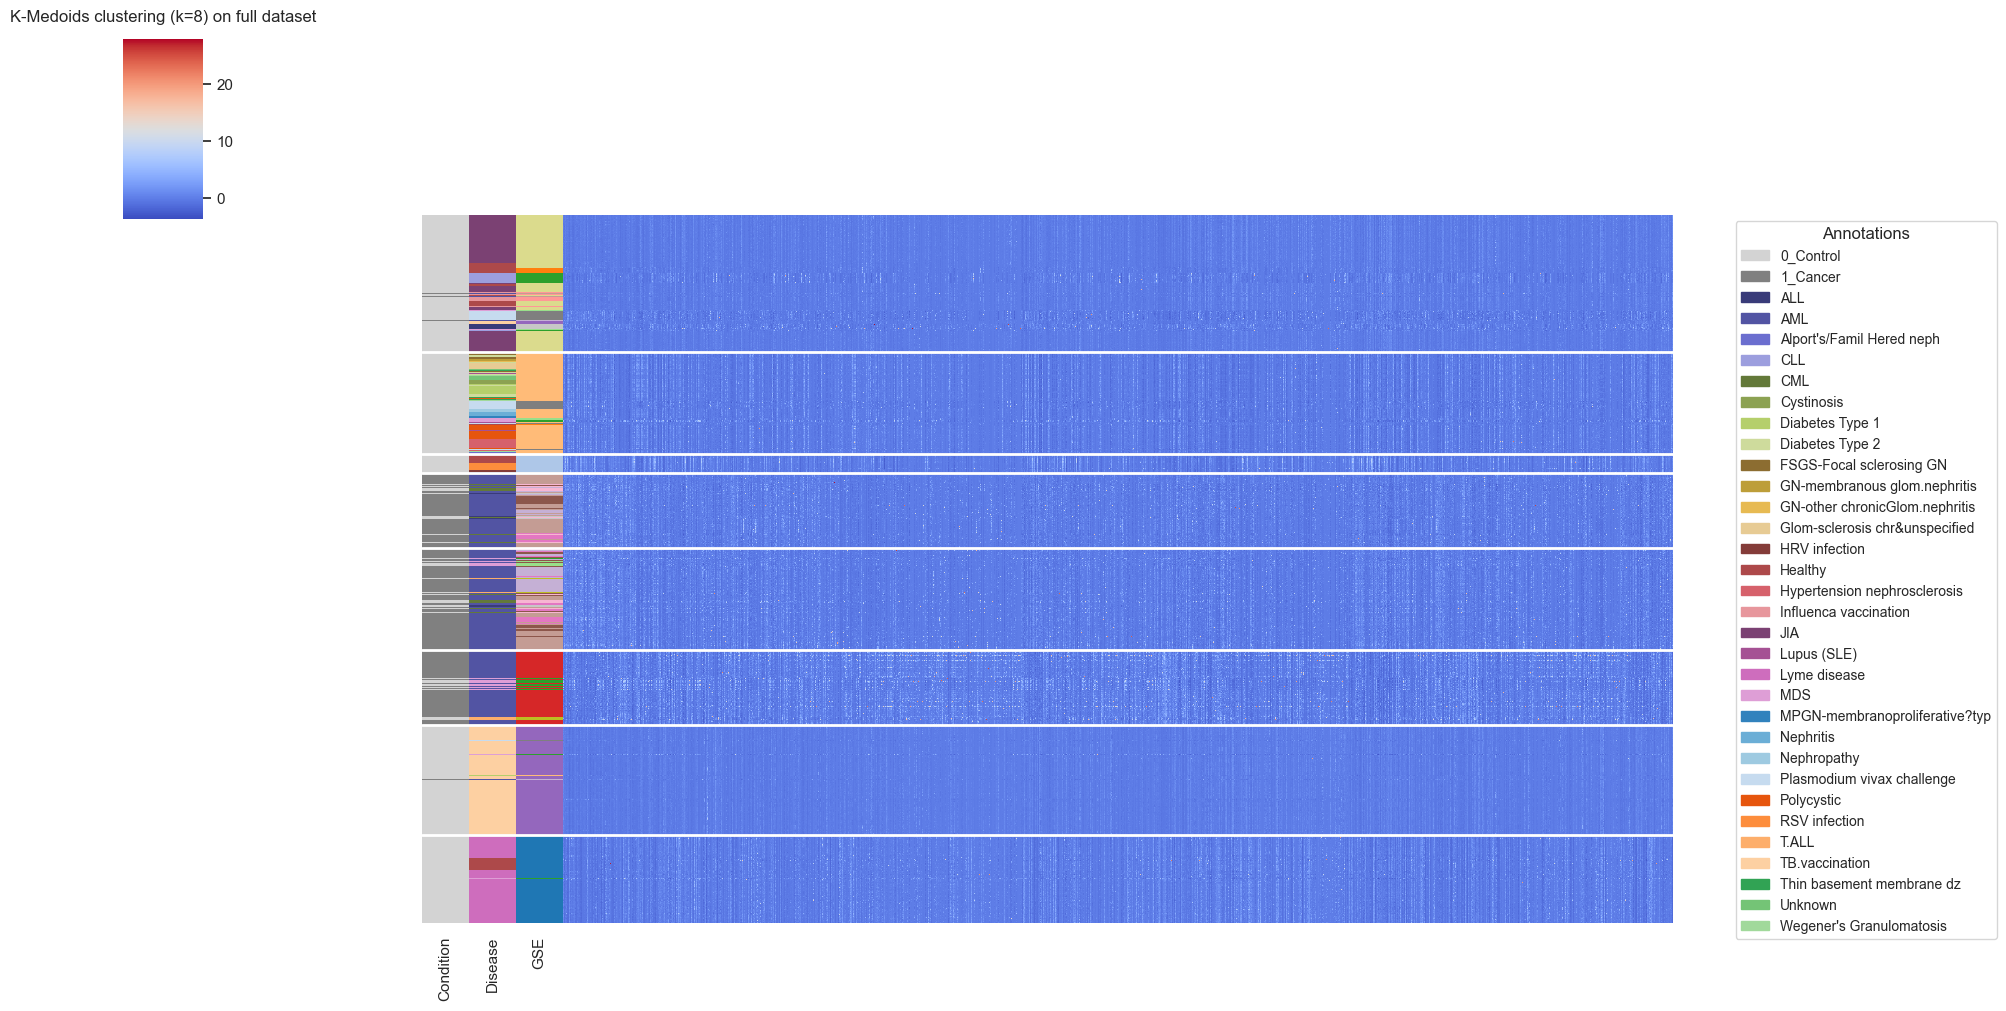

In [37]:
# comparse results with k-medoids clustering heatmap with k=8
dataset = utils.kmedoids_clustering_heatmap(data_train_val, k=8, name="case_study_1")

In [38]:
# Filter for samples where Disease is AML
dataset.groupby(['Disease', 'cluster']).size().unstack(fill_value=0)

/var/folders/8g/7wdchs993770j0nbzbt5p0_r0000gn/T/ipykernel_62157/3466181036.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset.groupby(['Disease', 'cluster']).size().unstack(fill_value=0)


cluster,0,1,2,3,4,5,6,7
Disease,,,,,,,,
ALL,5,0,1,3,3,0,0,0
AML,3,0,0,72,97,71,2,0
Alport's/Famil Hered neph,0,2,0,0,0,0,0,0
CLL,13,0,0,0,0,0,0,0
CML,0,0,0,8,6,0,0,0
Cystinosis,0,4,0,0,0,0,0,0
Diabetes Type 1,0,11,0,0,0,0,1,0
Diabetes Type 2,0,9,0,0,0,0,0,0
FSGS-Focal sclerosing GN,0,6,0,0,0,0,0,0


The k-medoids clustering applied to the expression data without supervision reveals key differences compared to the Forest-Guided Clustering (FGC) results.

From the heatmap and summary table above:
- AML samples, which were cleanly grouped into a single distinct cluster using FGC, are now scattered across three different clusters (clusters 2, 3, and 4). Each of these clusters also contains non-AML samples, including MDS, CML, and ALL cases, reducing the specificity of AML separation.
- Other leukemia types (e.g., CLL, ALL, CML, MDS) are also not clearly separated into dedicated clusters, suggesting that unsupervised clustering fails to isolate leukemia types effectively.
- Several clusters (e.g., clusters 0, 1, 6, and 7) are instead dominated by non-leukemic diseases such as JIA, TB-vaccination, or Lyme disease. These disease-specific groupings indicate that stronger expression patterns unrelated to leukemia are driving the clustering structure.

This result highlights an important limitation of purely unsupervised approaches: The most prominent sources of variation in high-dimensional expression data may not align with the clinical or biological question of interest. In contrast, the supervised FGC approach leverages model-driven proximity, enabling more targeted discovery of biologically or clinically relevant subgroups—such as the AML-specific cluster. This underscores the value of integrating predictive models into clustering for goal-oriented subgroup discovery.